In [1]:
import numpy as np
import matplotlib

# Embed fonts into PDF/PS files
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.colors

import scipy.integrate

# Progress bars
import tqdm.notebook

# to make copies of arrays
import copy

In [2]:
import scipy.optimize

In [3]:
matplotlib.rcParams.update({'font.size': 7, 'axes.linewidth': 0.5, 'xtick.major.width': 0.5, 'xtick.minor.width': 0.5, 
                            'ytick.major.width': 0.5,'ytick.minor.width': 0.5, 'xtick.major.pad':2,'ytick.major.pad':2})
matplotlib.rcParams.update({'font.family':'sans-serif','font.sans-serif':['Arial']})

In [4]:
def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2
            for (c1, c2) in zip(rgb, bg_rgb)]

# Define parameters

In [5]:
# Data taken from Arenz et al. 2008, Fig. 1G
arenz_data = np.array([[9.92689248942709, 4.122790122862343],
                        [20.021881428338318, 8.354626263598984],
                        [29.872911166215914, 13.083689775915978]])

np.mean(arenz_data[:,1]/arenz_data[:,0])

0.4235228205522715

In [5]:
## Physiological parameters
# see Materials and Methods for bibliographic information on sources

# mvn head sensitvity in the light: 0.38 sp/s / deg/s for ~0.85 gain -- Beraneck & Cullen 2007
# => k_eye ~= 2.2

# Eye movement response to optogenetic stimulation (Payne et al. 2019)
# ~0.1 deg/s / sp/s = k_eye * w_PC => w_PC ~= 0.05

# average learning in one day ~20-40% (Kimpo et al. 2014, Boyden & Raymond 2003)
# delta w ~= delta g/g_0 * v_0*k_MF / w_pc_mvn*k_PF
# delta g/g_0 ~= 0.3 = > delta w ~= -2.6
# => for ~50% decrease during training (Jang, Shim et al. 2020), set w_i = 5

# memory retention ~75% after 24 hr calculated from Boyden & Raymond 2003

params = {
    'mf_0': 55, # Lasker et al. 2008
    'pf_0': 14, # Arenz et al. 2008 -- assume each MF EPSC evokes a GC spike
    'cf_0': 1,
    'mf_sensitivity': 0.14, # Lasker et al. 2008
    'pf_sensitivity': 0.42, # Arenz et al. 2008 (See above)
    'w_i': 5, # calculated from Jang, Shim et al. 2020 as above
    'w_pc_mvn': 0.05, # calculated from Payne et al. 2019 as above
    'k_eye': 2.2, # calculated from Beraneck & Cullen 2007 as above
    'k_v':2.75e-5, # empirically, to get 75% retention
    'tau_f': 0.017, # fast average ~= 1 min
    'tau_mvn': 0.7, # tau_f,v: average of activity being integrated at MVN
    'tau_learn': 0.15, # Boyden & Raymond 2003
    'tau_post': 5, # consistent with 4 hour window, Attwell et al. 2002
    'k_LTD': 0.648, # to get delta w ~= -2.6
    'beta_rs':1, # to match CF response curve from Guo et al. 2014
}
# Set k_LTP so that LTP and LTD contributions to plasticity at w offset when not learning
params['k_LTP'] = params['w_i']/params['pf_0'] + params['k_LTD']*params['cf_0']

## Behavioral parameters

# Kimpo et al. 2014, Nguyen-Vu et al. 2013, Boyden & Raymond 2003
stim_freq = 1 
peak_velocity_learn = 15 # deg/s
peak_velocity_post = 15

# Define function for head velocity
head_learn = lambda t: peak_velocity_learn*np.sin(2*np.pi*stim_freq*3600*t)
head_post_input = lambda t: peak_velocity_post*np.sin(2*np.pi*stim_freq*3600*t) # w/post-training input
head_post_no_input = lambda t: 0 # w/o post-training input

# Define function for visual target motion
target_learn = lambda t: -peak_velocity_learn*np.sin(2*np.pi*stim_freq*3600*t) # increase gain to 2
target_post = lambda t: 0

In [6]:
params['k_LTP']

1.0051428571428571

In [7]:
gain = lambda w_h, v: params['k_eye']*((params['mf_sensitivity']*v - 
                                    params['pf_sensitivity']*params['w_pc_mvn']*(w_h - params['w_i'])))

In [8]:
# initial gain ~- 0.4 in mice (Katoh et al. 2015, Boyden & Raymond 2003)
g_init = 0.4
v_0_ = lambda g_init: g_init/(params['k_eye']*params['mf_sensitivity'])

v_0 = v_0_(g_init)

In [9]:
print(v_0)

1.2987012987012985


In [10]:
# Spontaneous firing rate of PCs ~50 sp/s (Katoh et al. 2015) 
# and MVNs is ~57 sp/s (Nelson et al. 2003)

# Calculate PC and MVN offsets so that this is the firing rate at baseline
params['pc_0'] = 50
params['mvn_0'] = 57 - params['mf_0']*v_0_(g_init) + params['w_pc_mvn']*50

In [11]:
# Get offsets
params['pc_0'], params['mvn_0']

(50, -11.928571428571416)

In [12]:
# Slope of trajectories that would result in 100% consolidation 
# (limit of tau_mvn -> 0, no change in v during training)
perfect_gain_slope = params['w_pc_mvn']*params['pf_sensitivity']/params['mf_sensitivity']

In [13]:
# Value of k_v that would give 100% consolidation in the ideal case
ideal_max_k_v = lambda sigma_h2: perfect_gain_slope/(params['tau_post']
                                                       *(params['mf_0']*params['pf_0'] + 
                                                         params['mf_sensitivity']*params['pf_sensitivity']*sigma_h2))

# ODE solver code

We use built-in ODE solvers (implemented by `scipy.integrate`) to perform simulations. The ODE solvers take functions that have the current time value (`t`) and the state (`y`) at that time as arguments and return a vector of the same size as `y` that gives the instantaneous derivative. We also provide a function for the Jacobian, which takes the same arguments and returns the Jacobian matrix.

We solve a system of five variables, with `y[0]` representing $w_H^+$, `y[1]` representing $v$, `y[2]` representing $\langle\text{MF}(t)(\text{PC}(t)-\text{PC}_0)\rangle_{\tau_{f,v}}$, `y[3]` representing $\langle\text{PF}(t)\rangle_{\tau_{f,w}}$ and `y[4]` representing $\langle\text{PF}(t)\text{CF}(t)\rangle_{\tau_{f,w}}$. The solver takes arguments `head` and `target` corresponding to $\dot{H}$ and the visual target motion, respectively.

In [14]:
# Function to pass to ODE solver
def heterosynapticOnline(t, y, head, target, learn, params):
    '''
    head: a function taking a time argument that returns the head velocity
    target: a function taking a time argument that returns the visual target velocity
    learn: set to True if in the training period, False if in the post-training period
    params: list containing the physiological parameters
    
    '''
    w_He = y[0]
    v = y[1]
    
    g = params['k_eye']*(params['mf_sensitivity']*v - 
                         params['pf_sensitivity']*params['w_pc_mvn']*(w_He-params['w_i']))
    retinal_slip = target(t) - (1-g)*head(t)
    
    delta_mf = params['mf_sensitivity']*head(t)
    delta_pf = params['pf_sensitivity']*head(t)
    delta_cf = np.tanh(-params['beta_rs']*retinal_slip)*learn
    
    # two time constants for learning and post-training, as in Yamazaki et al. 2015
    if learn:
        tau_w = params['tau_learn']
    else:
        tau_w = params['tau_post']
    mf = params['mf_0'] + delta_mf
    pf = params['pf_0'] + delta_pf
    cf = params['cf_0'] + delta_cf

    
    delta_pc = (w_He - params['w_i'])*pf
    
    dydt = np.zeros(5)
    dydt[0] = 1/tau_w * (-y[0] + params['k_LTP']*y[3] - params['k_LTD']*y[4])
    dydt[1] = params['k_v']*(-y[2])
    dydt[2] = 1/params['tau_mvn'] * (-y[2] + mf*delta_pc)
    dydt[3] = 1/params['tau_f'] * (-y[3] + pf)
    dydt[4] = 1/params['tau_f'] * (-y[4] + pf*cf)
    
    return dydt

# Jacobian 
def heteroOnlineJac(t, y, head, target, learn, params):
    w_He = y[0]
    v = y[1]
    
    g = params['k_eye']*(params['mf_sensitivity']*v - 
                         params['pf_sensitivity']*params['w_pc_mvn']*(w_He-params['w_i']))
    retinal_slip = target(t) - (1-g)*head(t)
    
    delta_mf = params['mf_sensitivity']*head(t)
    delta_pf = params['pf_sensitivity']*head(t)
    delta_cf = np.tanh(-params['beta_rs']*retinal_slip)*learn
    
    if learn:
        tau_w = params['tau_learn']
    else:
        tau_w = params['tau_post']
    mf = params['mf_0'] + delta_mf
    pf = params['pf_0'] + delta_pf
    
    dgdw = -params['k_eye']*params['w_pc_mvn']*params['pf_sensitivity']
    dgdv = params['k_eye']*params['mf_sensitivity']
    
    jac = -1/params['tau_f']*np.eye(5)
    jac[0,:] = 1/tau_w*np.array([-1, 0, 0, params['k_LTP'], -params['k_LTD']]) 
    jac[1,:] = params['k_v']*np.array([0, -1, 0, 0, 0])
    jac[2,:] = 1/params['tau_mvn']*np.array([-mf, 0, -1, 0, 0])
    jac[4,:2] = -pf*(1-delta_cf**2)*params['beta_rs']*head(t)/params['tau_f']*np.array([dgdw, dgdv])
    
    return jac

In [15]:
def simulateTrainingOnline(y0, T_learn, T_post, head_learn, head_post, target_learn, target_post, params, 
                     dt_learn = 1/3600, dt_post = 60/3600, max_step_post = 1/3600*0.25, returnSeparate=False, dense_output=True):
    '''Simulate a training and post-training period. 
    y0: initial condition
    T_learn: time (h) of training period
    T_post: time (h) of post-training period
    head_learn: function taking one argument (t) and returning head velocity at t during the training period
    head_post: function taking one argument (t) and returning head velocity at t during the post-training period
    target_learn: function taking one argument (t) and returning visual target velocity at t during the training period
    target_post: function taking one argument (t) and returning visual target velocity at t during the post-training period
    params: physiological parameters list
    dt_learn: training time step (for plotting)
    dt_post: post-training time step (for plotting)
    max_step_post: max_step parameter for solver during post-training period, default: half a cycle of input
    returnSeparate: if True, returns separate variables for the training and post-training periods
    dense_output: parameter passed to solver
    '''
    
    t_learn = np.arange(0, int(T_learn/dt_learn))*dt_learn
    t_post = np.arange(0, int((T_post-T_learn)/dt_post))*dt_post + T_learn
    y_learn = []
    y_post = []
    
    if T_learn > 0:
        sol_learn = scipy.integrate.solve_ivp(lambda t,y: heterosynapticOnline(t,y, head_learn, target_learn, True, params), [0, T_learn], y0, 
                                      jac=lambda t,y: heteroOnlineJac(t,y,head_learn, target_learn,True,params), method='Radau', dense_output=dense_output)

        if dense_output:
            y0_next = sol_learn.sol(T_learn)
            y_learn = sol_learn.sol(t_learn)
        else:
            y0_next = sol_learn.y[:,-1]
            t_learn = sol_learn.t
            y_learn = sol_learn.y
        
    else:
        y0_next = y0
        
    if T_post > 0:
        sol_post = scipy.integrate.solve_ivp(lambda t,y: heterosynapticOnline(t,y, head_post, target_post, False, params), [T_learn,T_post],y0_next,
                                      jac=lambda t,y: heteroOnlineJac(t,y,head_post, target_post, False, params), method='Radau', max_step=max_step_post, dense_output=dense_output)
        if dense_output:
            y_post = sol_post.sol(t_post)
        else:
            t_post = sol_post.t
            y_post = sol_post.y

    if returnSeparate:
        return t_learn, y_learn, t_post, y_post
    else:
        y_sol = np.hstack(y_learn, y_post)
        t_sol = np.concatenate((t_learn,t_post))
        return t_sol, y_sol

# Figure 2A-D

In [14]:
T_learn = 0.5 # h
T_post = 24 # h

# Initial conditions
y_0 = np.array([params['w_i'], v_0, 0, params['pf_0'], params['pf_0']*params['cf_0']])

In [17]:
# with post-training input
t_learn, y_learn, t_post, y_post_input = simulateTrainingOnline(y_0, T_learn, T_post, head_learn, head_post_input, 
                                                        target_learn, target_post, params, returnSeparate=True)
y_input = np.hstack((y_learn, y_post_input))
gain_input = gain(y_input[0,:], y_input[1,:])

In [18]:
t_sol = np.concatenate((t_learn, t_post))

In [19]:
# gain achieved during training
gain_learn = gain(y_learn[0,:], y_learn[1,:])
# % Consolidation
print((gain_input[-1]-gain_input[0])/(gain_learn[-1]-gain_learn[0]))

0.757186025250979


## Figure 2B,C: Change in weights and gain

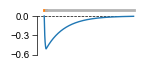

In [19]:
# Change in w
plt.figure(figsize=(1.25, 0.5))
plt.plot([-2,24], [0,0],'k--',lw=0.5)
# Input/no input conditions are identical
plt.plot(t_sol, (y_input[0,:]-params['w_i'])/y_input[0,0],lw=1, clip_on=False)

plt.plot([0, 0.5],[0.1,]*2,  c='C1', lw=2, clip_on=False)
plt.plot([0.5, 24], [0.1,]*2,  c=(0.7,)*3, lw=2, clip_on=False)

plt.xlim([-2,24])
plt.ylim([-0.6,0])
ax = plt.gca()

ax.xaxis.set_visible(False)
# ax.set_xticks([0, 24])
# ax.set_xticks([12], minor=True)
# ax.set_xticklabels([0, 24])

ax.set_yticks([0, -0.3, -0.6])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

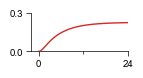

In [20]:
# Change in v
plt.figure(figsize=(1.25, 0.5))
plt.plot(t_sol, (y_input[1,:]-y_input[1,0])/y_input[1,0], c='C3',lw=1)
plt.ylim([0, 0.3])
plt.xlim([-2,24])

ax = plt.gca()

ax.set_xticks([0, 24])
ax.set_xticks([12], minor=True)
ax.set_xticklabels([0, 24])
ax.set_yticks([0, 0.3])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [21]:
# Change in gain due to consolidated memory (v only)
# gain_no_input_v = gain(params['w_i'], y_no_input[1,:])
gain_input_v = gain(params['w_i'], y_input[1,:])

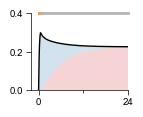

In [22]:
plt.figure(figsize=(1.25,1))
plt.fill_between(t_sol, np.zeros(len(t_sol)), gain_input_v/gain_input_v[0]-1, facecolor='C3',alpha=0.2)
plt.fill_between(t_sol, gain_input_v/gain_input_v[0]-1,gain_input/gain_input[0]-1,  facecolor='C0',alpha=0.2 )
plt.plot(t_sol, gain_input/gain_input[0]-1, c='k',lw=1)

plt.plot([0, 0.5],[0.4,]*2,  c='C1', lw=2, clip_on=False)
plt.plot([0.5, 24], [0.4,]*2,  c=(0.7,)*3, lw=2, clip_on=False)


plt.ylim([0, 0.4])
plt.xlim([-2,24])
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0, 24])
ax.set_xticks([12], minor=True)
ax.set_xticklabels([0, 24])

## Figure 2D: Phase plot

In [23]:
ww, vv = np.meshgrid(np.array([-2.5, -1.5, -0.5, 0.5, 1.5, 2.5]), np.linspace(0.9, 1.7, 4))

In [24]:
dw = 1/params['tau_post']*(-ww)
dv = -params['k_v']*(params['mf_0']*params['pf_0'])*ww

dw_norm = dw/np.sqrt(dw**2+dv**2)
dv_norm = dv/np.sqrt(dw**2+dv**2)

Gain is $g = k_E(k_\text{MF} v - w_\text{PC}k_\text{PF} w)$. If, after training the gain is $g_\text{train}$, then the constant gain line is
$$
v = \frac{1}{k_\text{MF}}\left(\frac{g_\text{train}}{k_E} + w_\text{PC}k_\text{PF}w\right).
$$
The line intersects the top of the $v$-axis at
$$
w_\text{max} = \frac{k_\text{MF} v_\text{max} - g_\text{train}/k_E}{w_\text{PC}k_\text{PF}}.
$$

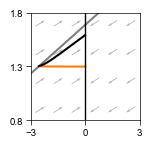

In [25]:
plt.figure(figsize=(1.4,1.4))
ylims = [0.8, 1.8]
xlims = [-3,3]

# Flow field
plt.quiver(ww, vv, dw_norm, dv_norm, pivot='middle', scale=10, angles='xy', color=(0.7, 0.7, 0.7, 1))

# Perfect consolidation line
w_max = (params['mf_sensitivity']*ylims[1] - gain_learn[-1]/params['k_eye'])/(params['w_pc_mvn']*params['pf_sensitivity'])
plt.plot([xlims[0], w_max], (np.array([xlims[0],w_max])*params['w_pc_mvn']*params['pf_sensitivity'] + gain_learn[-1]/params['k_eye'])/params['mf_sensitivity'],
        c=(0.5, 0.5, 0.5))

# Trajectories
plt.plot(y_learn[0,:]-params['w_i'], y_learn[1,:], c='C1')
plt.plot(y_post_input[0,:]-params['w_i'], y_post_input[1,:], c='k')

# Attractor
plt.plot([0, 0], ylims, c='k', lw=1)

plt.ylim(ylims)
plt.xlim(xlims)

ax = plt.gca()
ax.set_xticks([-3, 0, 3])
ax.set_yticks([0.8, 1.3, 1.8]);

# Figure 2E: 3 days of training

In [ ]:
days = 3
y_repeated_temp = []
y0_repeated = np.array([params['w_i'], v_0, 0, params['pf_0'], params['pf_0']*params['cf_0']])
rs_online = lambda t: -head_learn(t) # x2 training

for d in tqdm.notebook.trange(days):
    t_1, y_1, t_2, y_2 = simulateTrainingOnline(y0_repeated, 0.5, 24, head_learn, head_post_input, 
                              target_learn, target_post, params,  returnSeparate=True)
    y_repeated_temp.append(y_1)
    y_repeated_temp.append(y_2)
    y0_repeated = y_2[:,-1]

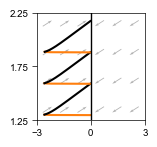

In [27]:
plt.figure(figsize=(1.4,1.4))

# Trajectories
for d in range(days):
    plt.plot(y_repeated_temp[2*d][0,:]-params['w_i'], y_repeated_temp[2*d][1,:],c='C1')
    plt.plot(y_repeated_temp[2*d+1][0,:]-params['w_i'], y_repeated_temp[2*d+1][1,:],c='k')
    
ylims = [1.25, 2.25]
# Attractor
plt.plot([0,0],ylims,'k', lw=1)

xlims = [-3, 3] 
ylimrange = ylims[1]-ylims[0]
xlimrange = xlims[1]-xlims[0]

# Plot phase arrows
ww_phase, vv_phase = np.meshgrid(xlims[0] + np.linspace(0.1,0.9,6)*xlimrange,ylims[0] + np.linspace(0.1,0.9,4)*ylimrange)
dw_phase = 1/params['tau_post']*(-ww_phase)
dv_phase = -params['k_v']*(params['mf_0']*params['pf_0'] + 
                                    params['mf_sensitivity']*params['pf_sensitivity']*(0.5*peak_velocity_post**2))*ww_phase

dw_phase_norm = dw_phase/np.sqrt(dw_phase**2+dv_phase**2)
dv_phase_norm = dv_phase/np.sqrt(dw_phase**2+dv_phase**2)
plt.quiver(ww_phase, vv_phase, dw_phase_norm, dv_phase_norm, pivot='middle', scale=10, angles='xy', color=(0.7, 0.7, 0.7, 1))

ax = plt.gca()

ax.set_yticks([1.25, 1.75, 2.25]);
plt.xticks([-3, 0, 3])

plt.ylim(ylims)
plt.xlim(xlims)

In [28]:
w_repeated = np.concatenate([y_repeated_temp[d][0,:] for d in range(2*days)])
v_repeated = np.concatenate([y_repeated_temp[d][1,:] for d in range(2*days)])

In [29]:
t_repeated = np.concatenate([np.concatenate((t_1, t_2)) + 24*d for d in range(days)])

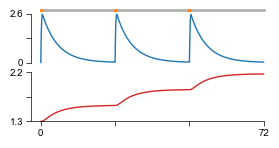

In [30]:
plt.figure(figsize=(3,1.4))
ax=plt.subplot(2,1,1)


plt.plot(t_repeated/24, -(w_repeated - w_repeated[0]), clip_on=False, lw=1)

for d in range(days):
    plt.plot([d, d+1/24], [2.8,]*2, c='C1', lw=2, clip_on=False)
    plt.plot([d+1/24, d+1], [2.8,]*2, c=(0.7,)*3, lw=2, clip_on=False)

plt.xlim([-0.13, 3])

plt.ylim([0, 2.6])
ax.set_yticks([0, 1.3, 2.6])
ax.set_yticklabels([0, '', 2.6]);
ax.xaxis.set_visible(False)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)



ax = plt.subplot(2,1,2)
plt.plot(t_repeated/24, v_repeated, c='C3', clip_on=False, lw=1)
plt.xlim([-0.13, 3])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylim([1.3, 2.2])
plt.yticks([1.3, 1.75, 2.2], [1.3,'',2.2])
plt.xticks([0,1,2,3],[0,'','',72]);

# Figure S1 

Here we show that, in the presence of information about errors, the circuit can fully reduce errors.

In [33]:
dt_ = 60/3600
t_sol_online = np.arange(0, int(48/dt_))*dt_
target_online = lambda t:0 # x1 training (for visualization purposes)

In [59]:
sol_learn_online = scipy.integrate.solve_ivp(lambda t,y: heterosynapticOnline(t,y, head_learn, target_online, True, params), [0, 48], y_0, 
                                  jac=lambda t,y: heteroOnlineJac(t,y,head_learn, target_online,True,params), method='Radau', dense_output=True, max_step = 0.25*1/3600)

In [60]:
y_online = sol_learn_online.sol(t_sol_online)
gain_online = gain(y_online[0,:], y_online[1,:])

## Figure S1A: Change in weights and gain

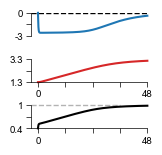

In [61]:
plt.figure(figsize=(1.5,1.5))
ax = plt.subplot(3,1,1)
plt.plot([-3, 48],[0,0],'k--',lw=1)
# plt.plot(sol_learn.t, sol_learn.y[0,:]-params['w_i'],c='C0',clip_on=False)
plt.plot(t_sol_online, y_online[0,:]-params['w_i'],c='C0',clip_on=False)

plt.yticks([-3, -1.5,0], [-3, '', 0])
plt.ylim([-3, 0])
plt.xlim([-3, 48])


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xticks([])


ax = plt.subplot(3,1,2)

plt.plot(t_sol_online, y_online[1,:],c='C3',clip_on=False)
plt.ylim([v_0,3.3])
plt.xlim([-3, 48])
plt.yticks([1.3,2.3,3.3],[1.3,'',3.3])
plt.xticks([0, 12,24,36,48],[0, '','', '',48])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = plt.subplot(3,1,3)
plt.plot([-3,36],[1,1],'--',lw=1, c=(0.7,)*3, clip_on=False)
plt.plot(t_sol_online, gain_online,c='k',clip_on=False)
plt.xlim([-3,36])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim([0.4, 1])
plt.xticks([0,12,24,36,48],[0, '', '', '',48]);
plt.yticks([0.4, 0.7,1],[0.4, '', 1]);

plt.subplots_adjust(hspace=1)

## Figure S1B: Phase plot

The equation for the $w$-nullcline is:
$$
w + k_\text{LTD}k_\text{PF}\langle\dot{H}(t)\tanh((g^\text{target} - g(w,v))\dot{H}(t))\rangle \approx w + \frac{1}{T}k_\text{LTD}k_\text{PF}\int_0^T\text{d}t\ \dot{H}(t)\tanh((g^\text{target} - g(w,v))\dot{H}(t)) = 0.
$$

To plot the curve, we pick points in $v$ and solve for the corresponding values of $w$. We estimate the average by calculating the integral over half a cycle of the head stimulus.

In [51]:
g_des = 1
T = 0.5/3600
avg_equation = lambda t,w,v,g_des: head_learn(t)*np.tanh(params['beta_rs']*(g_des - gain(w+params['w_i'],v))*head_learn(t))
v_null_eq_approx = lambda w,v,g_des: w + 1/T*params['k_LTD']*params['pf_sensitivity']*scipy.integrate.quad(lambda t: avg_equation(t,w,v,g_des), 0, T)[0]

In [57]:
v_null = np.linspace(1, 4)
w_null_approx = np.array([scipy.optimize.root_scalar(lambda w: v_null_eq_approx(w,v,g_des), bracket=[-3, 3]).root for v in v_null])

In [53]:
ww, vv = np.meshgrid(np.array([-2.5, -1.5, -0.5, 0.5, 1.5, 2.5]), np.linspace(1.25, 3.75, 5))

In [54]:
dw = -1/params['tau_learn']*np.vstack([[v_null_eq_approx(ww[i,j], vv[i,j], g_des) for j in range(ww.shape[1])] for i in range(ww.shape[0])])

dv = -params['k_v']*(params['mf_0']*params['pf_0'])*ww

dw_norm = dw/np.sqrt(dw**2+dv**2)
dv_norm = dv/np.sqrt(dw**2+dv**2)

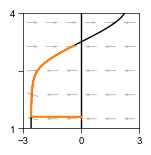

In [63]:
plt.figure(figsize=(1.5,1.5))
plt.quiver(ww, vv, dw_norm, dv_norm, pivot='middle', scale=10, angles='xy', color=(0.7, 0.7, 0.7, 1))

# plt.plot(w_null, v_null,'.-',c='k',lw=1)
plt.plot(w_null_approx, v_null,c='k',lw=1)
plt.plot([0,]*2,[1, 4],c='k',lw=1)
plt.plot(y_online[0,:]-params['w_i'], y_online[1,:],c='C1')
plt.ylim([1,4])

plt.xticks([-3, 0, 3])
plt.yticks([1, 2.5, 4], [1, '', 4])

## Figure S1C: Nullclines for different target gain values

In [64]:
g_des_set = np.linspace(0.5, 1, 5) # multiple target gain values to plot
w_nulls = np.zeros((len(g_des_set), len(v_null)))
for i in range(len(g_des_set)):
    w_nulls[i,:] = np.array([scipy.optimize.root_scalar(lambda w: v_null_eq_approx(w,v, g_des_set[i]), bracket=[-2.6, 2.6]).root for v in v_null])

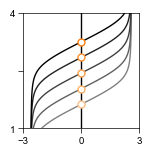

In [65]:
plt.figure(figsize=(1.5, 1.5))
plt.plot([0,]*2,[1, 4],c='k',lw=1)
alpha_ = np.linspace(0, 0.5, len(g_des_set))[::-1]
orange_ = matplotlib.colors.to_rgb('C1')
for i in range(len(g_des_set)):
    plt.plot(w_nulls[i,:], v_null,lw=1,c=[alpha_[i],]*3)
    plt.plot(0, g_des_set[i]/(params['mf_sensitivity']*params['k_eye']),'o', c=make_rgb_transparent(orange_, (1,)*3, 1-alpha_[i]), markerfacecolor='w',ms=5)
    
plt.ylim([1,4])
plt.xticks([-3, 0, 3])
plt.yticks([1, 2.5, 4],[1,'',4])

# Figure 3

### Perturbation simulation

We simulated the effect of perturbations of random magnitude to the value of the early-learning weight, made regularly every 10 min (in simulation time) for a total of 24 hours (i.e., 144 perturbations). We then calculated the distribution of the final value of each of 250 sample paths. 

See SI Appendix, S1.4 for derivation of an analytical expression describing the variance of the late-learning weight $v$ over time in response to perturbations.

We then compared the variance in $v$ for 1 day of training and post-training with perturbations using a fast rate of learning at $v$ to 4 days of training using a slower rate of learning.

In [26]:
T_learn = 0.5
T_post = 24 # h

T_noise = 10/60 # h (= 10 min)
num_perturbations_train = int(T_learn/T_noise)
num_perturbations_post = int((T_post - T_learn)/T_noise) # total number of perturbations
num_perturbations = num_perturbations_train + num_perturbations_post

trials = 250 # number of sample paths

rng = np.random.default_rng(seed=42)

perturbation_amplitude = 0.1

noisy_input =  perturbation_amplitude*2*(rng.random((trials, days, num_perturbations))-0.5)

dt_perturb = 60/3600 # h = 1 min

In [26]:
dt_learn = 1/3600 # h = 1 s

t_noise = np.arange(0, noise_len/(dt_learn),1)*(dt_learn) # time vector between perturbations
t_noise_total = np.arange(0, trial_len/dt_learn, 1)*dt_learn # full time vector for a sample path
y_noise_complete = np.zeros((trials, 2, len(t_noise_total)+1))

y0 = np.array([params['w_i'], v_0, 0, params['pf_0'], params['pf_0']*params['cf_0']]) 

In [27]:
E = np.exp(-noise_len/params['tau_post'])
mfpf2 = (params['mf_0']*params['pf_0'] + params['mf_sensitivity']*params['pf_sensitivity']
                                            *0.5*(peak_velocity_post**2))

var_v_f = lambda k_v, trials, perturb_size: (1/3*perturb_size**2*(k_v * params['tau_post'] * mfpf2 )**2*
                               ((trials+1) - 2*E*(1-E**(trials+1))/(1-E)
                                + E**2*(1-E**(2*(trials+1)))/((1-E**2))))

## Faster learning rate (Figure 3A,E)

Using the same learning rate at $v$ as in the simulations in Figure 2.

### Perturbations only (no training)

In [28]:
# Make a copy of the parameters that can be altered separately
params_perturb_fast = copy.deepcopy(params)
params_perturb_fast['tau_mvn'] = params['tau_f']
# set the value of \tau_{f,v} to \tau_f so that trajectories are straighter in phase space

In [29]:
y0 = np.array([params['w_i'], v_0, 0, params['pf_0'], params['pf_0']*params['cf_0']])

In [ ]:
noise_ends_fast = np.zeros((5,trials)) # value at the end of sample paths
y_noise_fast = np.zeros((trials,2,len(t_noise)*num_perturbations+1)) # time course for plotting example


for tt in tqdm.notebook.trange(trials, desc='Trial'):
    y0_noisy = np.copy(y0)
    y_noise_temp = np.zeros((num_perturbations, 5, len(t_noise))) # temporary array for this trial
    
    for b in tqdm.notebook.trange(num_perturbations, desc='Perturbation', leave=False):
        y0_noisy[0] += noisy_input[tt,0,b]
        sol_learn_noisy = scipy.integrate.solve_ivp(lambda t,y: heterosynapticOnline(t,y, head_post_input, target_post, False, params_perturb_fast), [0, T_noise], y0_noisy, 
                                      jac=lambda t,y: heteroOnlineJac(t,y,head_post_input, target_post,False,params_perturb_fast), method='Radau', dense_output=True)
        y_noise_temp[b,:,:] = sol_learn_noisy.sol(t_noise)
        y0_noisy = sol_learn_noisy.sol(T_noise)
    noise_ends_fast[:,tt] = np.copy(y0_noisy)
    
    y_noise_fast[tt,:,0] = np.copy(y0[:2])
    y_noise_fast[tt,0,1:] = np.concatenate((y_noise_temp[:,0,:]))
    y_noise_fast[tt,1,1:] = np.concatenate((y_noise_temp[:,1,:]))
    
np.save('files/y_noise_fast.npy',y_noise_fast) # w and v at all time points across simulations
np.save('files/noise_ends_fast.npy',noise_ends_fast) # final state of system across simulations

In [29]:
##### Files are too large to upload to GitHub

# y_noise_fast = np.load('files/y_noise_fast.npy')
# noise_ends_fast = np.load('files/noise_ends_fast.npy')

In [23]:
# Example for plotting
# 0, 13, 20, 23
y_noise_fast_example = y_noise_fast[27, :, :] # ind 6

In [24]:
## Generate colormap to show trajectory over time
cyan_hsv = matplotlib.colors.rgb_to_hsv(matplotlib.colors.to_rgb('C9'))
stops = [0, 0.33,1]
bright_stops = [1,1,0.25]
sat_stops = [0.1, 0.5, 1]
c_points = matplotlib.colors.hsv_to_rgb([(cyan_hsv[0], sat_stops[i], bright_stops[i]) for i in range(len(stops))])

color_labels = ['red','green','blue']

cdict = {}
for i in range(3):
    cdict[color_labels[i]] = [(stops[j], c_points[j][i], c_points[j][i]) for j in range(len(c_points))]

cmap = matplotlib.colors.LinearSegmentedColormap('cyans', cdict)

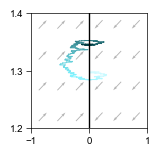

In [30]:
plt.figure(figsize=(1.5,1.5))

c_ = np.linspace(0,1,num_perturbations)

for i in range(num_perturbations):
    start_ = int(T_noise/dt_perturb) * i
    end_ = int(T_noise/dt_perturb) * (i+1)
    plt.plot(y_noise_fast_example[0,start_:end_+1]-params['w_i'], 
             y_noise_fast_example[1,start_:end_+1], c=cmap(c_[i]),lw=0.75)

yr = 0.1 # 0.5
ylims = [1.3-yr, 1.3+yr]
plt.plot([0,0],ylims,'k', lw=1)
xlims = [-1, 1] 
ylimrange = ylims[1]-ylims[0]
xlimrange = xlims[1]-xlims[0]

plt.ylim(ylims)
plt.xlim(xlims)

ww_phase, vv_phase = np.meshgrid(xlims[0] + np.linspace(0.1,0.9,6)*xlimrange,
                                 ylims[0] + np.linspace(0.1,0.9,4)*ylimrange)
dw_phase = 1/params['tau_post']*(-ww_phase)
dv_phase = -params_perturb_fast['k_v']*(params['mf_0']*params['pf_0'] + 
                                    params['mf_sensitivity']*params['pf_sensitivity']*(0.5*peak_velocity_post**2))*ww_phase

dw_phase_norm = dw_phase/np.sqrt(dw_phase**2+dv_phase**2)
dv_phase_norm = dv_phase/np.sqrt(dw_phase**2+dv_phase**2)

plt.quiver(ww_phase, vv_phase, dw_phase_norm, dv_phase_norm, pivot='middle', scale=10, angles='xy', color=(0.7, 0.7, 0.7, 1))


ax = plt.gca()

ax.set_yticks(np.linspace(ylims[0],ylims[1], 3));
ax.set_xticks(np.linspace(xlims[0],xlims[1], 3));

## For color bar with ticks:
# cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=None, cmap=cmap),ax=ax,orientation='horizontal',location='top')

### Training w/o perturbations

In [93]:
t_f_learn, y_f_learn, t_f_post, y_f_post = simulateTrainingOnline(y_0, 0.5, 24, head_learn,
                                                                  head_post_no_input, # head_post_input, 
                                                            target_learn, target_post, params_perturb_fast, returnSeparate=True)


In [352]:
t_f = np.concatenate((t_f_learn, t_f_post))
y_f = np.hstack((y_f_learn, y_f_post))

In [770]:
gain_f_learn = gain(y_f_learn[0,:], y_f_learn[1,:])

gain_f_post = gain(y_f_post[0,:], y_f_post[1,:])

In [771]:
# Gain after training
gain_f_learn[-1]

0.5246821845061571

In [772]:
# Gain after consolidation
gain_f_post[-1]

0.49058320649607623

In [774]:
# % consolidation
(gain_f_post[-1]-gain_f_learn[0])/(gain_f_learn[-1]-gain_f_learn[0])

0.7265128282349193

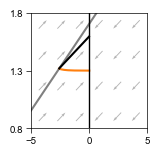

In [209]:
plt.figure(figsize=(1.5,1.5))
# plt.quiver(ww, vv, dw_norm, dv_norm, pivot='middle', scale=10, angles='xy', color=(0.7, 0.7, 0.7, 1))


yr = 0.5
ylims = [1.3-yr, 1.3+yr]

xlims = [-5, 5]

w_max = (params['mf_sensitivity']*ylims[1] - gain_f_learn[-1]/params['k_eye'])/(params['w_pc_mvn']*params['pf_sensitivity'])

# Plot perfect consolidation line
plt.plot([xlims[0], w_max], (np.array([xlims[0], w_max])*params['w_pc_mvn']*params['pf_sensitivity'] + gain_f_learn[-1]/params['k_eye'])/params['mf_sensitivity'],
        c=(0.5, 0.5, 0.5))

plt.plot(y_f_learn[0,:]-params['w_i'], y_f_learn[1,:], c='C1')
plt.plot(y_f_post[0,:]-params['w_i'], y_f_post[1,:], c='k')

# Plot attractor

plt.plot([0,0],ylims,'k', lw=1)
 
ylimrange = ylims[1]-ylims[0]
xlimrange = xlims[1]-xlims[0]

plt.ylim(ylims)
plt.xlim(xlims)

ww_phase, vv_phase = np.meshgrid(xlims[0] + np.linspace(0.1,0.9,6)*xlimrange,ylims[0] + np.linspace(0.1,0.9,4)*ylimrange)
dw_phase = 1/params['tau_post']*(-ww_phase)

dv_phase = -params_perturb_fast['k_v']*(params['mf_0']*params['pf_0'] + 
                                    params['mf_sensitivity']*params['pf_sensitivity']*(0.5*peak_velocity_post**2))*ww_phase

dw_phase_norm = dw_phase/np.sqrt(dw_phase**2+dv_phase**2)
dv_phase_norm = dv_phase/np.sqrt(dw_phase**2+dv_phase**2)

plt.quiver(ww_phase, vv_phase, dw_phase_norm, dv_phase_norm, pivot='middle', scale=10, angles='xy', color=(0.7, 0.7, 0.7, 1))


ax = plt.gca()
ax.set_yticks(np.linspace(ylims[0],ylims[1], 3));
ax.set_xticks(np.linspace(xlims[0],xlims[1], 3));

### Training with perturbations

In [ ]:
y_train_perturb_fast = np.zeros((trials, 5, len(t_noise)*num_perturbations))

for tt in tqdm.notebook.trange(100, trials,desc='Repetition #'):
    y0_repeated = np.array([params['w_i'], v_0, 0, params['pf_0'], params['pf_0']*params['cf_0']])
    
    for b in tqdm.notebook.trange(num_perturbations, leave=False, desc='Perturbation #'):
        if b > 0: #  and tt < num_perturbations_train:
            y0_repeated[0] += noisy_input[tt,0,b]
        if b < num_perturbations_train:
            learn_ = True
            target_ = rs_online
        else:
            learn_ = False
            target_ = target_post
        sol_noisy = scipy.integrate.solve_ivp(lambda t,y: heterosynapticOnline(t,y, head_learn, target_, learn_, params_perturb_fast), [0, T_noise], y0_repeated, 
                                          jac=lambda t,y: heteroOnlineJac(t,y,head_learn, target_,learn_,params_perturb_fast), method='Radau', dense_output=True)


        # y_repeated_temp.append(sol_noisy.sol(t_noise))
        # t_repeated_temp.append(t_noise + T_noise*tt)
        y_train_perturb_fast[tt, :, b*perturbation_len:(b+1)*perturbation_len] = sol_noisy.sol(t_noise)
        y0_repeated = sol_noisy.y[:,-1]

# np.save('files/y_noise_fast_train.npy',y_train_perturb_fast)

In [414]:
# y_train_perturb_fast = np.load('files/y_noise_fast_train.npy')

In [464]:
t_train_perturb_fast = np.concatenate([t_noise + T_noise*tt for tt in range(num_perturbations)])

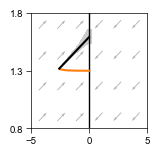

In [759]:
plt.figure(figsize=(1.5,1.5))

yr = 0.5
ylims = [1.3-yr, 1.3+yr]

xlims = [-5, 5]

w_max = (params['mf_sensitivity']*ylims[1] - gain_f_learn[-1]/params['k_eye'])/(params['w_pc_mvn']*params['pf_sensitivity'])
 
ylimrange = ylims[1]-ylims[0]
xlimrange = xlims[1]-xlims[0]

plt.ylim(ylims)
plt.xlim(xlims)

ww_phase, vv_phase = np.meshgrid(xlims[0] + np.linspace(0.1,0.9,6)*xlimrange,ylims[0] + np.linspace(0.1,0.9,4)*ylimrange)
dw_phase = 1/params['tau_post']*(-ww_phase)

dv_phase = -params_perturb_fast['k_v']*(params['mf_0']*params['pf_0'] + 
                                    params['mf_sensitivity']*params['pf_sensitivity']*(0.5*peak_velocity_post**2))*ww_phase

dw_phase_norm = dw_phase/np.sqrt(dw_phase**2+dv_phase**2)
dv_phase_norm = dv_phase/np.sqrt(dw_phase**2+dv_phase**2)

plt.quiver(ww_phase, vv_phase, dw_phase_norm, dv_phase_norm, pivot='middle', scale=10, angles='xy', color=(0.7, 0.7, 0.7, 1))

for ttt in range(0,len(t_train_perturb_fast)):
    plt.fill_between(np.mean(y_train_perturb_fast[:,0,ttt]-params['w_i']) + np.std(y_train_perturb_fast[:,0,ttt])*np.array([1,-1]), 
                 [np.mean(y_train_perturb_fast[:,1,ttt]) - np.std(y_train_perturb_fast[:,1,ttt]),]*2,
                 [np.mean(y_train_perturb_fast[:,1,ttt]) + np.std(y_train_perturb_fast[:,1,ttt]),]*2, color=(0.8,)*3,edgecolor=None)

# Plot attractor

plt.plot([0,0],ylims,'k', lw=1)

plt.plot(y_f_learn[0,:]-params['w_i'], y_f_learn[1,:], c='C1')
plt.plot(y_f_post[0,:]-params['w_i'], y_f_post[1,:], c='k')



ax = plt.gca()
ax.set_yticks(np.linspace(ylims[0],ylims[1], 3));
ax.set_xticks(np.linspace(xlims[0],xlims[1], 3));

## Slower learning rate (Figure 3B,F)

Using a learning rate at $v$ that would lead in the ideal case to 20% consolidation.

In [536]:
# Make a copy of the parameters that can be altered separately
params_perturb_slow = copy.deepcopy(params)
params_perturb_slow['tau_mvn'] = params['tau_f']
# set the value of \tau_{f,v} to \tau_f so that trajectories are straighter in phase space

params_perturb_slow['k_v'] = 0.177*ideal_max_k_v(0.5*peak_velocity_post**2)

In [526]:
print(params_perturb_slow['k_v'])

6.953252254978335e-06


### Perturbations only

In [ ]:
noise_ends_slow = np.zeros((5,trials)) # value at the end of sample paths
y_noise_slow = np.zeros((trials,2,len(t_noise)*num_perturbations+1)) # time course for plotting example

for tt in tqdm.notebook.trange(trials, desc='Trial'):
    y0_noisy = np.copy(y0)
    y_noise_temp = np.zeros((num_perturbations, 5, len(t_noise))) # temporary array for this trial
    
    for b in tqdm.notebook.trange(num_perturbations, desc='Perturbation', leave=False):
        y0_noisy[0] += noisy_input[tt,0,b]
        sol_learn_noisy = scipy.integrate.solve_ivp(lambda t,y: heterosynapticOnline(t,y, head_post_input, target_post, False, params_perturb_slow), [0, T_noise], y0_noisy, 
                                      jac=lambda t,y: heteroOnlineJac(t,y,head_post_input, target_post,False,params_perturb_slow), method='Radau', dense_output=True)
        y_noise_temp[b,:,:] = sol_learn_noisy.sol(t_noise)
        y0_noisy = sol_learn_noisy.sol(T_noise)
    noise_ends_slow[:,tt] = np.copy(y0_noisy)
    
    y_noise_slow[tt,:,0] = np.copy(y0[:2])
    y_noise_slow[tt,0,1:] = np.concatenate((y_noise_temp[:,0,:]))
    y_noise_slow[tt,1,1:] = np.concatenate((y_noise_temp[:,1,:]))
    
# np.save('files/y_noise_slow.npy',y_noise_slow)
# np.save('files/noise_ends_slow.npy',noise_ends_slow)

In [35]:
# Files are too large to upload to GitHub

# y_noise_slow = np.load('files/y_noise_slow.npy')
# noise_ends_slow = np.load('files/noise_ends_slow.npy')

In [714]:
# Example for plotting (same perturbation time course as fast learning)
y_noise_slow_example = y_noise_slow[27, :, :]

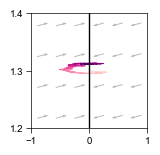

In [722]:
fig = plt.figure(figsize=(1.5,1.5))
cmap = matplotlib.colormaps['RdPu']

noise_total = num_perturbations
c_ = np.linspace(0.1,1,noise_total)
for i in range(noise_total):
    start_ = int(T_noise/dt_) * i
    end_ = int(T_noise/dt_) * (i+1)
    plt.plot(y_noise_slow_example[0,start_:end_+1]-params['w_i'], 
             y_noise_slow_example[1,start_:end_+1], c=cmap(c_[i]),lw=0.75)

yr = 0.1 # 0.5
ylims = [1.3-yr, 1.3+yr]
plt.plot([0,0],ylims,'k', lw=1)
xlims = [-1, 1] # [-5, 5]
ylimrange = ylims[1]-ylims[0]
xlimrange = xlims[1]-xlims[0]

plt.ylim(ylims)
plt.xlim(xlims)

ww_phase, vv_phase = np.meshgrid(xlims[0] + np.linspace(0.1,0.9,6)*xlimrange,
                                 ylims[0] + np.linspace(0.1,0.9,4)*ylimrange)
dw_phase = 1/params['tau_post']*(-ww_phase)
dv_phase = -params_perturb_slow['k_v']*(params['mf_0']*params['pf_0']+
                                      params['mf_sensitivity']*params['pf_sensitivity']*(0.5*peak_velocity_post**2))*ww_phase

dw_phase_norm = dw_phase/np.sqrt(dw_phase**2+dv_phase**2)
dv_phase_norm = dv_phase/np.sqrt(dw_phase**2+dv_phase**2)

plt.quiver(ww_phase, vv_phase, dw_phase_norm, dv_phase_norm, pivot='middle', scale=10, angles='xy', color=(0.7, 0.7, 0.7, 1))


ax = plt.gca()

ax.set_yticks(np.linspace(ylims[0],ylims[1], 3));
ax.set_xticks(np.linspace(xlims[0],xlims[1], 3));

# To plot with color bar with ticks:
# cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0.1, vmax=1), cmap=cmap),ax=ax,orientation='horizontal',location='top')

### Training w/o perturbations

In [ ]:
# Training with no perturbations
y_repeated_temp_no_perturb = []
y0_repeated = np.array([params['w_i'], v_0, 0, params['pf_0'], params['pf_0']*params['cf_0']])

for d in tqdm.notebook.trange(days):
    t_1, y_1, t_2, y_2 = simulateTrainingOnline(y0_repeated, 0.5, 24, head_learn, head_post_input, 
                              target_learn, target_post, params_perturb_slow,  returnSeparate=True, dt_learn=60/3600)
    y_repeated_temp_no_perturb.append(y_1)
    y_repeated_temp_no_perturb.append(y_2)
    y0_repeated = y_2[:,-1]

In [557]:
gain(y_repeated_temp_no_perturb[-1][0,-1],y_repeated_temp_no_perturb[-1][1,-1])

0.4906573785575796

In [558]:
w_no_perturb_combined = np.concatenate([y_repeated_temp_no_perturb[i][0,:] for i in range(days*2)])
v_no_perturb_combined = np.concatenate([y_repeated_temp_no_perturb[i][1,:] for i in range(days*2)])

### Training with perturbations (4 days)

In [129]:
rs_online = lambda t: -head_learn(t) # x2 training


In [198]:
perturbation_len = int(T_noise/dt_perturb)

In [138]:
t_noise = np.arange(int(T_noise/dt_perturb))*dt_perturb

In [ ]:
y_train_perturb_slow = np.zeros((trials, 5, len(t_noise)*num_perturbations*days))

for tt in tqdm.notebook.trange(trials,desc='Repetition #'):
    y0_repeated = np.array([params['w_i'], v_0, 0, params['pf_0'], params['pf_0']*params['cf_0']])
    
    for d in tqdm.notebook.trange(days, leave=False, desc='Day'):
        for b in tqdm.notebook.trange(num_perturbations, leave=False, desc='Perturbation #'):
            if b > 0: #  and tt < num_perturbations_train:
                y0_repeated[0] += noisy_input[tt,d,b]
            if b < num_perturbations_train:
                learn_ = True
                target_ = rs_online
            else:
                learn_ = False
                target_ = target_post
            sol_noisy = scipy.integrate.solve_ivp(lambda t,y: heterosynapticOnline(t,y, head_learn, target_, learn_, params_perturb_slow), [0, T_noise], y0_repeated, 
                                              jac=lambda t,y: heteroOnlineJac(t,y,head_learn, target_,learn_,params_perturb_slow), method='Radau', dense_output=True)


            # y_repeated_temp.append(sol_noisy.sol(t_noise))
            # t_repeated_temp.append(t_noise + T_noise*tt)
            y_train_perturb_slow[tt, :, (d*num_perturbations + b)*perturbation_len:(d*num_perturbations+(b+1))*perturbation_len] = sol_noisy.sol(t_noise)
            y0_repeated = sol_noisy.y[:,-1]

# np.save('files/y_noise_slow_train',y_train_perturb_slow)

In [565]:
# y_train_perturb_slow = np.load('files/y_noise_slow_train.npy')

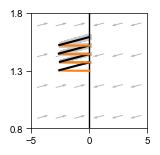

In [760]:
plt.figure(figsize=(1.5,1.5))

xlims = [-5, 5] 
yr = 0.5
ylims = [1.3-yr, 1.3+yr]


# Attractor
plt.plot([0,0],ylims,'k', lw=1)
 
ylimrange = ylims[1]-ylims[0]
xlimrange = xlims[1]-xlims[0]

# Plot phase arrows
ww_phase, vv_phase = np.meshgrid(xlims[0] + np.linspace(0.1,0.9,6)*xlimrange,ylims[0] + np.linspace(0.1,0.9,4)*ylimrange)
dw_phase = 1/params['tau_post']*(-ww_phase)
dv_phase = -params_perturb_slow['k_v']*(params['mf_0']*params['pf_0'] + 
                                    params['mf_sensitivity']*params['pf_sensitivity']*(0.5*peak_velocity_post**2))*ww_phase

dw_phase_norm = dw_phase/np.sqrt(dw_phase**2+dv_phase**2)
dv_phase_norm = dv_phase/np.sqrt(dw_phase**2+dv_phase**2)
plt.quiver(ww_phase, vv_phase, dw_phase_norm, dv_phase_norm, pivot='middle', scale=10, angles='xy', color=(0.7, 0.7, 0.7, 1))

for ttt in range(0,len(t_repeated)):
    plt.fill_between(np.mean(y_train_perturb_slow[:,0,ttt]-params['w_i']) + np.std(y_train_perturb_slow[:,0,ttt])*np.array([1,-1]), 
                 [np.mean(y_train_perturb_slow[:,1,ttt]) - np.std(y_train_perturb_slow[:,1,ttt]),]*2,
                 [np.mean(y_train_perturb_slow[:,1,ttt]) + np.std(y_train_perturb_slow[:,1,ttt]),]*2, color=(0.8,)*3,edgecolor=None)

# No noise
for d in range(days):
    plt.plot(y_repeated_temp_no_perturb[2*d][0,:]-params['w_i'], y_repeated_temp_no_perturb[2*d][1,:],c='C1')
    plt.plot(y_repeated_temp_no_perturb[2*d+1][0,:]-params['w_i'], y_repeated_temp_no_perturb[2*d+1][1,:],c='k')
    
ax = plt.gca()

ax.set_yticks(np.linspace(ylims[0],ylims[1], 3));
ax.set_xticks(np.linspace(xlims[0],xlims[1], 3));

plt.ylim(ylims)
plt.xlim(xlims)

## Histogram for Figure 3C

In [38]:
# Histogram bins for Fig. 2c, bottom

edges = np.arange(0,16,1)*0.42 - 0.45

In [735]:
n_bins = 15 #sqrt(250) ~= 15
bar_width = 0.4/(n_bins-1)
bar_centers = bar_width*np.arange(0,n_bins,1) + 1.1
edges = np.concatenate((bar_centers - bar_width, [bar_centers[-1]+bar_width]))

In [736]:
fast_counts, edges = np.histogram(noise_ends_fast[1,:], edges)

In [737]:
slow_counts,slow_edges = np.histogram(noise_ends_slow[1,:], edges)

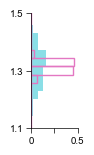

In [743]:
plt.figure(figsize=(0.6,1.5))
yr = 0.2
xr = 0.5

plt.barh(bar_centers, fast_counts/np.sum(fast_counts), edges[1]-edges[0], alpha=0.5, facecolor='C9', lw=0.5)
plt.barh(bar_centers, slow_counts/np.sum(slow_counts), edges[1]-edges[0], edgecolor='C6', facecolor='None')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks([0, xr/2, xr])
ax.set_xticklabels([0, '', xr])
ax.set_yticks(np.linspace(1.3-yr, 1.3+yr, 3))
plt.ylim([1.30-yr, 1.3+yr])
plt.xlim([0, xr])

## Empirical time course of variance of $v$ w/o perturbations (Fig. 3D)

In [744]:
vars_fast = np.var(y_noise_fast[:,1,:],axis=0)
vars_slow = np.var(y_noise_slow[:,1,:],axis=0)

In [747]:
# Subsample only points in time course corresponding to peturbation times
kk = np.arange(num_perturbations)*T_noise
inds_perturb = np.array(kk/dt_,dtype=int)
inds_ = np.concatenate((inds_perturb[1:]-1, [len(t_train_perturb_fast)-1]))

In [609]:
bar_centers_fast = 0.5*(fast_edges[1:]-fast_edges[:-1]) + fast_edges[:-1]

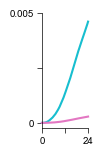

In [758]:
plt.figure(figsize=(0.6,1.5))
ax = plt.gca()

# kk_ = np.arange(60)
plt.plot(kk, vars_fast[inds_],c='C9',clip_on=False)
plt.plot(kk, vars_slow[inds_],c='C6', clip_on=False)


plt.xlim([0, 24])
plt.ylim([-0.00025,0.005])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks(np.linspace(0,24,3))
ax.set_xticklabels([0,'',24])

ax.set_yticks(np.linspace(0,0.005,3))
ax.set_yticklabels([0,'',0.005])
plt.savefig('figures/figure 3/var_over_time_noise.pdf')

## Histograms for training with perturbations (Fig. 3G)

In [810]:
v_std_train_slow = np.std(y_train_perturb_slow[:,1,-1])
v_mu_train_slow = np.mean(y_train_perturb_slow[:,1,-1])

v_std_train_fast = np.std(y_train_perturb_fast[:,1,-1])
v_mu_train_fast = np.mean(y_train_perturb_fast[:,1,-1])

In [ ]:
edges = np.arange(0,16,1)*0.42 - 0.45
n_bins = 15
bar_width = 0.4/(n_bins-1)
bar_centers = bar_width*np.arange(0,n_bins,1) + 1.39
edges = np.concatenate((bar_centers - bar_width, [bar_centers[-1]+bar_width]))

In [763]:
fast_counts_v, fast_edges = np.histogram(y_train_perturb_fast[:,1,-1], bins=edges)
slow_counts_v, slow_edges = np.histogram(y_train_perturb_slow[:,1,-1], bins=edges)

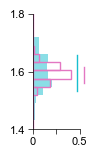

In [834]:
plt.figure(figsize=(0.6,1.5))

xr = 0.5
yr = 0.2
plt.barh(bar_centers, fast_counts_v/np.sum(fast_counts_v), edges[1]-edges[0], 
          alpha=0.5, facecolor='C9', lw=0.5)
plt.barh(bar_centers, slow_counts_v/np.sum(slow_counts_v), edges[1]-edges[0],
          edgecolor='C6', facecolor='None')

# Plot standard deviations
plt.plot([xr+0.05,]*2, [v_mu_train_slow - v_std_train_slow, v_mu_train_slow + v_std_train_slow],'C6',lw=1,clip_on=False)
plt.plot([xr-0.025,]*2, [v_mu_train_fast - v_std_train_fast, v_mu_train_fast + v_std_train_fast],'C9',lw=1,clip_on=False)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks([0, xr/2, xr])
ax.set_xticklabels([0, '', xr],fontsize=8)
plt.yticks(np.linspace(1.6-yr, 1.6+yr, 3),fontsize=8)
plt.ylim([1.60-yr, 1.6+yr])

plt.xlim([0, xr])

## Empirical time course of variance w/perturbations (Fig. 3H)

In [572]:
t_repeated = np.concatenate([np.concatenate([t_noise + T_noise*tt + d*T_post for tt in range(num_perturbations)]) for d in range(days)])

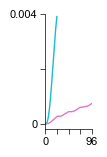

In [827]:
plt.figure(figsize=(0.6,1.5))
ax = plt.gca()

plt.plot(t_train_perturb_fast, np.var(y_train_perturb_fast[:,1,:], axis=0),c='C9',lw=1)
plt.plot(t_repeated, np.var(y_train_perturb_slow[:,1,:], axis=0),c='C6',lw=1)

plt.xlim([0, 96])
plt.ylim([-0.0002,0.004])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks(np.linspace(0,96,5))
ax.set_xticklabels([0,'','','',96],fontsize=8)

ax.set_yticks(np.linspace(0,0.004,3))
ax.set_yticklabels([0,'',0.004],fontsize=8)

## Without sensory input
(For comparison to Hebbian rule in Fig. 5)

In [23]:
head_post_no_input = lambda t: 0

In [25]:
# with post-training input
t_learn, y_learn, t_post, y_post_no_input = simulateTrainingOnline(y_0, T_learn, T_post, head_learn, head_post_no_input, 
                                                        target_learn, target_post, params, returnSeparate=True)
y_no_input = np.hstack((y_learn, y_post_no_input))
gain_input = gain(y_no_input[0,:], y_no_input[1,:])

In [27]:
# % difference in v after 24 h
y_input[1,-1]/y_no_input[1,-1]

1.0014572173246263